使用EdgeTpu應用在語音模型預測之簡單實例
此Colab只到最後edgetpu_compiler編譯轉換完tflite檔案，實際下載使用轉換後tflite檔案請在實機環境進行，需要搭配Google Usb Accelerator。

Author Github：[s123600g/asr_edgetpu_demo](https://github.com/s123600g/asr_edgetpu_demo)

有關Google Usb Accelerator，可參考[Google Coral - Get started with the USB Accelerator](https://coral.withgoogle.com/docs/accelerator/get-started/#)

使用Tensorflow版本-1.15(No-GPU)，[Install TensorFlow with pip](https://www.tensorflow.org/install/pip)

---
關於如何使用此Google Colab

請先確認**Edit**-->**NoteBook settings**內

1.**Runtime Type** --> *Python3*

2.**Hardware accelerator** --> *None(Use CPU)*

執行此Colab方式，**Runtime**-->**Run All**


---


資料集：內容為已先經過處理好之35個類別語音資料，每一個類別各有450個語音特徵，總共有15750個語音特徵資料。

最原始來源為使用在Tensorflow官方[ Simple Audio Recognition](https://www.tensorflow.org/tutorials/sequences/audio_recognition) ，例子內所使用之語音資料集[speech_commands_v0.02.tar.gz](https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz)


1.[audio_feature.zip](https://drive.google.com/open?id=11X-vlDNjCH4t98fRs5reBuSXolAUeh7b)

2.[validdata.zip](https://drive.google.com/open?id=1E-P9iiADzFGEi7Q8n5pcfsvzTGz0a8ul)

3.[audio_classlabels.txt](https://drive.google.com/open?id=15ZNeldZ8d8t9Fg3f9SImlpGn-PjclXb9)


---

關於此Colab執行階段分為以下程序

1.開發環境建置

2.Import python packages.

3.配置程式執行上所需參數

4.建立訓練過程視覺圖像化函式

5.建立產生資料及之處理過程所需函式

6.建立CNN模型函式與配置

7.產生訓練、測試、驗證資料集，並將數值進行正規化

8.進行量化(Quantization-aware training)訓練產生pb模型

9.進行pb模型轉換tflite

10.進行edgetpu_compiler編譯轉換tflite

11.下載經過edgetpu_compiler編譯轉換後tflite檔案

# 1.開發環境建置

In [1]:
! pwd

/content


# Install edgetpu_compiler

In [2]:
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

deb https://packages.cloud.google.com/apt coral-edgetpu-stable main


In [3]:
!sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB
!sudo apt update 
!sudo apt install edgetpu 

Executing: /tmp/apt-key-gpghome.vXUyGk2I5o/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 6A030B21BA07F4FB
gpg: key 6A030B21BA07F4FB: public key "Google Cloud Packages Automatic Signing Key <gc-team@google.com>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,332 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable/main amd64 Packages [1,382 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 ht

# Install tensorflow 1.15

In [4]:
!pip install tensorflow==1.15

# Get python packages requirement_notf.txt

In [5]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1o3I9FP9vxFWzf7HBhhns-6bZL1_b8CXb'  -O 'requirement_notf.txt'

will be placed in the single file you specified.

--2019-11-30 11:12:53--  https://docs.google.com/uc?export=download&id=1o3I9FP9vxFWzf7HBhhns-6bZL1_b8CXb
Resolving docs.google.com (docs.google.com)... 108.177.97.101, 108.177.97.102, 108.177.97.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/02tpo277e3ql44mf3p3qngcdl6dtr62s/1575108000000/13552193235433718899/*/1o3I9FP9vxFWzf7HBhhns-6bZL1_b8CXb?e=download [following]
--2019-11-30 11:12:53--  https://doc-04-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/02tpo277e3ql44mf3p3qngcdl6dtr62s/1575108000000/13552193235433718899/*/1o3I9FP9vxFWzf7HBhhns-6bZL1_b8CXb?e=download
Resolving doc-04-4g-docs.googleusercontent.com (doc-04-4g-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to

In [6]:
# !rm requirement_notf.txt
!ls

requirement_notf.txt  sample_data


# Install python package by requirement_notf.txt

In [7]:
!pip install -r requirement_notf.txt

# Download audio_feature.zip

In [8]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=11X-vlDNjCH4t98fRs5reBuSXolAUeh7b'  -O 'audio_feature.zip'

will be placed in the single file you specified.

--2019-11-30 11:13:02--  https://docs.google.com/uc?export=download&id=11X-vlDNjCH4t98fRs5reBuSXolAUeh7b
Resolving docs.google.com (docs.google.com)... 74.125.203.100, 74.125.203.101, 74.125.203.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘audio_feature.zip’

audio_feature.zip       [ <=>                ]   3.18K  --.-KB/s    in 0s      

2019-11-30 11:13:03 (39.4 MB/s) - ‘audio_feature.zip’ saved [3252]

Loading robots.txt; please ignore errors.
--2019-11-30 11:13:03--  https://docs.google.com/robots.txt
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘audio_feature.zip’

audio_feature.zip       [ <=>                ]     567  --.-KB/s    in 0s      

2019-11-30 11:13:03 (73.8 MB/s) - ‘audio_feature.zip’ sav

# Download class.db3

In [9]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1PY7AYjbjIqURZDPcDO02dJ2OJWju-as7'  -O 'class.db3'

will be placed in the single file you specified.

--2019-11-30 11:13:06--  https://docs.google.com/uc?export=download&id=1PY7AYjbjIqURZDPcDO02dJ2OJWju-as7
Resolving docs.google.com (docs.google.com)... 74.125.203.139, 74.125.203.101, 74.125.203.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.203.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qsg5he13g5qgsja0796fg56mbd5gan98/1575108000000/13552193235433718899/*/1PY7AYjbjIqURZDPcDO02dJ2OJWju-as7?e=download [following]
--2019-11-30 11:13:07--  https://doc-04-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qsg5he13g5qgsja0796fg56mbd5gan98/1575108000000/13552193235433718899/*/1PY7AYjbjIqURZDPcDO02dJ2OJWju-as7?e=download
Resolving doc-04-4g-docs.googleusercontent.com (doc-04-4g-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to

# Download validdata.zip

In [10]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1E-P9iiADzFGEi7Q8n5pcfsvzTGz0a8ul'  -O 'validdata.zip'

will be placed in the single file you specified.

--2019-11-30 11:13:09--  https://docs.google.com/uc?export=download&id=1E-P9iiADzFGEi7Q8n5pcfsvzTGz0a8ul
Resolving docs.google.com (docs.google.com)... 108.177.97.101, 108.177.97.102, 108.177.97.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hu7f6cfunp00viphp5jmlkrba14nkrf2/1575108000000/13552193235433718899/*/1E-P9iiADzFGEi7Q8n5pcfsvzTGz0a8ul?e=download [following]
--2019-11-30 11:13:09--  https://doc-0o-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hu7f6cfunp00viphp5jmlkrba14nkrf2/1575108000000/13552193235433718899/*/1E-P9iiADzFGEi7Q8n5pcfsvzTGz0a8ul?e=download
Resolving doc-0o-4g-docs.googleusercontent.com (doc-0o-4g-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to

In [0]:
# !rm -r audio_feature/
# !rm -r model/
# !rm -r plot_figure/
# !rm -r log_file/
# !rm -r DB/
# !rm -r tflite_model/validdata

# Create directory

In [12]:
!mkdir plot_figure/
!mkdir model/
!mkdir model/ModelCheckpoint
!mkdir log_file/
!mkdir log_file/audio_classlabels
!mkdir DB/
!mkdir tflite_model/
!ls

audio_feature.zip  DB	     model	  requirement_notf.txt	tflite_model
class.db3	   log_file  plot_figure  sample_data		validdata.zip


In [13]:
!mv class.db3 DB/
! ls DB/

class.db3


In [14]:
! ls tflite_model/validdata/

ls: cannot access 'tflite_model/validdata/': No such file or directory


In [15]:
!ls model/

ModelCheckpoint


In [16]:
!ls log_file/

audio_classlabels


# 解壓縮 audio_feature.zip

In [17]:
#unzip 如果要指定解壓縮到哪個路徑底下要加上-d '指定路徑位置'，例如 -d log_file/  解壓縮imgdata.zip log_file/底下
!unzip audio_feature.zip -d log_file/

Archive:  audio_feature.zip
warning [audio_feature.zip]:  401045 extra bytes at beginning or within zipfile
  (attempting to process anyway)
   creating: log_file/audio_feature/
   creating: log_file/audio_feature/happy/
  inflating: log_file/audio_feature/happy/2b3f509b_nohash_2.txt  
  inflating: log_file/audio_feature/happy/ceaadb24_nohash_0.txt  
  inflating: log_file/audio_feature/happy/1efdf53f_nohash_0.txt  
  inflating: log_file/audio_feature/happy/b6e6aa2e_nohash_0.txt  
  inflating: log_file/audio_feature/happy/1b88bf70_nohash_0.txt  
  inflating: log_file/audio_feature/happy/7bae88ed_nohash_0.txt  
  inflating: log_file/audio_feature/happy/0616de09_nohash_0.txt  
  inflating: log_file/audio_feature/happy/8d5d076d_nohash_1.txt  
  inflating: log_file/audio_feature/happy/0f7205ef_nohash_0.txt  
  inflating: log_file/audio_feature/happy/1fe4c891_nohash_0.txt  
  inflating: log_file/audio_feature/happy/f01a0d63_nohash_0.txt  
  inflating: log_file/audio_feature/happy/e6db3894_no

# 解壓縮 validdata.zip

In [18]:
#unzip 如果要指定解壓縮到哪個路徑底下要加上-d '指定路徑位置'，例如 -d tflite_model/  validdata.zip tflite_model/底下
!unzip validdata.zip -d tflite_model/

Archive:  validdata.zip
   creating: tflite_model/validdata/
   creating: tflite_model/validdata/down/
  inflating: tflite_model/validdata/down/29dce108_nohash_3.txt  


In [19]:
! ls tflite_model/validdata

down


In [20]:
!ls

audio_feature.zip  log_file  plot_figure	   sample_data	 validdata.zip
DB		   model     requirement_notf.txt  tflite_model


In [21]:
!ls log_file/audio_feature/

backward  dog	 follow   happy  marvin  on	sheila	tree	wow
bed	  down	 forward  house  nine	 one	six	two	yes
bird	  eight  four	  learn  no	 right	stop	up	zero
cat	  five	 go	  left	 off	 seven	three	visual


# Download audio_classlabels.txt

In [22]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=15ZNeldZ8d8t9Fg3f9SImlpGn-PjclXb9'  -O 'audio_classlabels.txt'
!mv audio_classlabels.txt log_file/audio_classlabels
!ls log_file/audio_classlabels

will be placed in the single file you specified.

--2019-11-30 11:13:59--  https://docs.google.com/uc?export=download&id=15ZNeldZ8d8t9Fg3f9SImlpGn-PjclXb9
Resolving docs.google.com (docs.google.com)... 108.177.97.101, 108.177.97.102, 108.177.97.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/msi31s2ou3gco8l6r995pkko4lqu3rlp/1575108000000/13552193235433718899/*/15ZNeldZ8d8t9Fg3f9SImlpGn-PjclXb9?e=download [following]
--2019-11-30 11:14:00--  https://doc-04-4g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/msi31s2ou3gco8l6r995pkko4lqu3rlp/1575108000000/13552193235433718899/*/15ZNeldZ8d8t9Fg3f9SImlpGn-PjclXb9?e=download
Resolving doc-04-4g-docs.googleusercontent.com (doc-04-4g-docs.googleusercontent.com)... 74.125.203.132, 2404:6800:4008:c03::84
Connecting to

#2.Import python packages.

In [23]:
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import backend as k
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras import backend as K

import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import random
import sqlite3
import os
import time

Using TensorFlow backend.


# 3.配置程式執行上所需參數.

In [0]:
#輸出訓練過程變化圖檔案參數配置
Plot_Figure_DirectoryName = "plot_figure"

#SQLite DB 參數配置
SQLite_DB_DirectoryName = "DB"
SQLite_name = "class.db3"
db_TableName = 'audioclass'
column_ClassNum = 'ClassNum'
column_Classname = 'ClassName'

#訓練後模型儲存參數設置
Model_DirectoryName = "model"
Model_Name = "Speech_Recognition_Model.h5"
Model_Weight_Name = "Speech_Recognition_Weight.h5"
Model_Path = os.path.join(os.getcwd(), Model_DirectoryName, Model_Name)
Model_Weight_Path = os.path.join(
        os.getcwd(), Model_DirectoryName, Model_Weight_Name)
Model_checkpoints_DirectoryName = "checkpoints"
Model_checkpoints_Path = os.path.join(
        os.getcwd(), Model_checkpoints_DirectoryName, Model_checkpoints_DirectoryName
    )

Model_ModelCheckpoint_DirectoryName = "ModelCheckpoint"
Model_ModelCheckpoint_Path = os.path.join(
        os.getcwd(), Model_DirectoryName, Model_ModelCheckpoint_DirectoryName
    )

Model_PB_Name = "frozen_model.pb"
Model_PB_Path = os.path.join(
        os.getcwd(), Model_DirectoryName, Model_PB_Name
    )

#轉換模型參數設置
Input_Model_Path = os.path.join(os.getcwd(), "model")
Output_Model_Name = "ASR_Model.tflite"
Output_Model_Path = os.path.join(
        os.getcwd(),Model_DirectoryName, Output_Model_Name)

input_arrays = ["conv2d_input"]
output_arrays = ["dense_1/Softmax"]

'''模型訓練參數配置-CNN'''
batch_size = 100
epochs = 20
quant_delay = 10
verbose = 1

#輸出檔案參數配置
Log_DirectoryName = "log_file"
log_file_type = "txt"
Log_FeatureData_DirectoryName = "audio_feature"
Log_ClassLabelsData_DirectoryName = "audio_classlabels"
Log_ClassLabelsData_name = str(
        Log_ClassLabelsData_DirectoryName + "." + log_file_type)

''' 設置模型訓練時之回調函數控制 '''
callbacks = [    
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(Model_ModelCheckpoint_Path, "ckpt_{epoch:02d}"),
        verbose=1,
        save_weights_only=False
    ),
]

Train_DataSet = []
Train_Labels = []
Test_DataSet = []
Test_Labels = []
Valid_DataSet = []
Valid_Labels = []
rep_dataset=[]
MFCC_Data = []
labels = []
class_num = 0
channel = 1  # 單一通道(single channel)

# 4.建立訓練過程視覺圖像化函式

In [0]:
def plot_figure(history, dir, figure_classname):

    __plot_acc(history, dir, figure_classname)

    # plt.subplot(1,2,1)

    __plot_loss(history, dir, figure_classname)

    # plt.show()


def __plot_acc(hist, path, figure_classname):
    '''
    輸出模型訓練過程之準確度變化圖
    '''

    acc = hist.history['acc']
    val_acc = hist.history['val_acc']

    # figure size
    plt.figure(figsize=(8, 8))
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title(figure_classname+'_Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train_acc', 'valid_acc'], loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(path, str(figure_classname+'_Accuracy.png')))
    # plt.show()


def __plot_loss(hist, path, figure_classname):
    '''
    輸出模型訓練過程之損失函數變化圖
    '''

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    # figure size
    plt.figure(figsize=(8, 8))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title(figure_classname+'_Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train_loss', 'valid_loss'], loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(path, str(figure_classname+'_Loss.png')))
    # plt.show()

# 5.建立產生資料及之處理過程所需函式

In [0]:
class_label = dict()
dbconn = sqlite3.connect(
            os.path.join(
                os.getcwd(),
                SQLite_DB_DirectoryName,
                SQLite_name
            )
)
curs = dbconn.cursor()

def SQL_Insert_Class_Labels():
        '''
          新增分類標籤與對應編號進SQLite DB。\n
          關於SQLite DB參數設置，可在"Config.py"內找到SQLite DB 參數配置區塊，有關參數資訊如下： \n
          "SQLite_DB_DirectoryName" --> 專案資料夾內放置SQLite DB單檔位置 \n
          "SQLite_name" --> SQLite DB單檔名稱 \n 
          "db_TableName" --> 使用之資料庫內資料表 \n
          "column_ClassNum" --> 使用之資料庫內資料表內資料欄位名稱，這裡是使用"ClassNum"欄位名稱 \n
          "column_Classname" --> 使用之資料庫內資料表內資料欄位名稱，這裡是使用"ClassName"欄位名稱 \n
        '''
    
        global class_num

        print("[Gen_DataSet]Start scanning class....", end="\n\n")

        ''' Run SQL DB Table Clearn '''
        SQL_delete_syntax = '''
        DELETE FROM {}
        '''.format(db_TableName)
        SQL_run = curs.execute(SQL_delete_syntax)

        if SQL_run:

            dbconn.commit()

        else:

            raise Exception("[Gen_DataSet]Run SQL_Delete_Syntax Faild !!")

        temp_read_content = ""

        ''' 判斷放置已編號之類別內容文字檔是否存在 '''
        if os.path.exists(os.path.join(os.getcwd(), Log_DirectoryName, Log_ClassLabelsData_DirectoryName, Log_ClassLabelsData_name)):

            ''' 讀取已編號之類別內容文字檔 '''
            with open(os.path.join(os.getcwd(), Log_DirectoryName, Log_ClassLabelsData_DirectoryName, Log_ClassLabelsData_name), "r") as read:

                temp_read_content = read.readlines()

            # 讀取擷取出來內容
            for read_data in temp_read_content:

                read_data = str(read_data).rstrip("\n").split(" ")

                ''' Run SQL_Insert_Syntax '''
                SQL_Insert_syntax = '''
                INSERT INTO {}('{}','{}')
                VALUES('{}','{}')
                '''.format(
                    db_TableName,
                    column_ClassNum,
                    column_Classname,
                    int(read_data[0]),
                    str(read_data[1]))
                SQL_run = curs.execute(SQL_Insert_syntax)

                if SQL_run:

                    dbconn.commit()
                    class_label[int(read_data[0])] = str(read_data[1])
                    class_num += 1

                else:

                    raise Exception(
                        "[Gen_DataSet]Run SQL_Insert_Syntax Faild !!")

            print("[Gen_DataSet]Class label：{}".format(
                class_label
            ))

        else:

            raise Exception("[Gen_DataSet] The file ['{}'] can not found !!".format(Log_ClassLabelsData_name))

def load_DataSet_File():
        '''
        讀取指定的目錄內所有分類內特徵值檔案，此方法最後會產生所有特徵值內容矩陣與分類標籤矩陣。\n
        讀取指定的目錄設置，可在Config.py內針對輸出檔案參數配置配置區塊，進行讀取資料來源配置位置。\n
        特徵值檔案與分類標籤資訊統一放在"Log_DirectoryName"指定的目錄名稱內，關於內部目錄結構參數設置如下：\n
        "Log_FeatureData_DirectoryName" --> 放置每一分類特徵值檔案總目錄 \n
        "Log_ClassLabelsData_DirectoryName" --> 放置分類標籤資訊與對應編號檔案總目錄 \n
        '''
        global class_num,labels,MFCC_Data
    
        print("\n[Gen_DataSet]Start Reading DataSet File....", end="\n\n")

        temp_read_content = ""
        temp_mfcc_feature = list()

        ''' 讀取放置所有分類語音特徵檔目錄內容 '''
        for read_classfloder in os.listdir(os.path.join(os.getcwd(), Log_DirectoryName, Log_FeatureData_DirectoryName)):

            print(
                "[Gen_DataSet]Current reading class name：['{}'].".format(
                    read_classfloder
                )
            )

            ''' 讀取放置所有分類語音特徵檔目錄內容-每一個分類目錄內檔案 '''
            for read_file in os.listdir(os.path.join(os.getcwd(), Log_DirectoryName, Log_FeatureData_DirectoryName, read_classfloder)):

                ''' 判斷每一個分類目錄內放置語音特徵文字檔目錄是否存在 '''
                if os.path.exists(os.path.join(os.getcwd(),Log_DirectoryName, Log_FeatureData_DirectoryName, read_classfloder, read_file)):

                    # print("{}".format(read_file))

                    # 串接每一個音頻特徵檔案對應分類位置
                    labels.append(read_classfloder)

                    ''' 讀取放置語音特徵檔案內容 '''
                    with open(os.path.join(os.getcwd(), Log_DirectoryName, Log_FeatureData_DirectoryName, read_classfloder, read_file), "r") as read:

                        temp_read_content = read.readlines()

                    ''' 將讀取內容作處理儲存至特徵清單 '''
                    for read_row in temp_read_content:

                        # print("{}".format(read_item))

                        # 將每一行先做去除尾巴換行符號，並進行資料切割
                        read_row = str(read_row).rstrip(" \n").split(" ")

                        temp_list = list()

                        # 讀取已完成去除尾巴換行符號與進行資料切割之每列內之欄位資料
                        for feature in read_row:

                            # 存放每一列的欄位資料
                            temp_list.append(float(feature))

                        # 存放一整列資料
                        temp_mfcc_feature.append(temp_list)

                    # 串接存放每一個音頻特徵檔案內容
                    MFCC_Data.append(temp_mfcc_feature)

                    temp_mfcc_feature = list()

        # print("[Gen_DataSet]Audio class quantity: {}".format(
        #     len(
        #         os.listdir(
        #             os.path.join(
        #                 os.getcwd(),
        #                 Log_DirectoryName,
        #                 Log_FeatureData_DirectoryName
        #             )
        #         )
        #     )
        # ))
             
        
        # 將存放所有分類音頻特徵內容清單轉為numpy array型態
        MFCC_Data = np.array(MFCC_Data)

        # 將存放所有分類音頻對應分類位置清單轉為numpy array型態
        labels = np.array(labels)

        
#         print("Normalizer MFCC Data:{}".format(MFCC_Data[0]))        
        
        print("[Gen_DataSet] MFCC_Data type: {}".format(type(MFCC_Data)))

        print("[Gen_DataSet] MFCC_Data shape: {}".format(MFCC_Data.shape))

        print("[Gen_DataSet] labels_data type: {}".format(type(labels)))

        print("[Gen_DataSet] labels_data shape: {}".format(labels.shape))

        print("[Gen_DataSet] Class quantity: {}".format(class_num))

        print()

        # print("{}".format(
        #     MFCC_Data[0]
        # ))

def shuffle_DataSet():
        '''
        將全部所有讀取的特徵值檔案內容與所屬分類標籤，進行資料矩陣內部打散排序。
        '''
        global labels,MFCC_Data

        # shuffle data
        perm_array = np.arange(len(MFCC_Data))
        np.random.shuffle(perm_array)
        MFCC_Data = MFCC_Data[perm_array]
        labels = labels[perm_array]

        # print("[Gen_DataSet]Labels：\n{}".format(
        #     labels
        # ))

def char_to_code():
        '''
        將所讀取的所有特徵對應分類標籤資訊矩陣內部，進行轉換成已分好之分類標籤對應編號。 \n
        例如：\n
        假設所有分類標籤對應編號資訊如下：\n
        {0: 'backward', 1: 'bed', 2: 'bird', 3: 'cat', 4: 'dog', 5: 'down', 6: 'eight', 7: 'five', 8: 'follow', 9: 'forward', 10: 'four', 11: 'go', 12: 'happy', 13: 'house', 14: 'learn', 15: 'left', 16: 'marvin', 17: 'nine', 18: 'no', 19: 'off', 20: 'on', 21: 'one', 22: 'right', 23: 'seven', 24: 'sheila', 25: 'six', 26: 'stop', 27: 'three', 28: 'tree', 29: 'two', 30: 'up', 31: 'visual', 32: 'wow', 33: 'yes', 34: 'zero'}\n\n
        原始所有特徵對應分類標籤資訊矩陣內容如下： \n
        ['wow', 'nine', 'five', ... ,'dog' ,'tree', 'forward'] \n \n
        轉換分類標籤對應編號後之所有特徵對應分類標籤資訊矩陣內容如下：\n
        [32 ,17,7, ... ,4,28,9]\n
        '''
    
        global labels

        for index in list(class_label.keys()):

            # print("{} {}".format(index, class_label[index]))

            labels = np.array(
                [int(index) if label == class_label[index]
                 else label for label in labels]
            )

        # print("[Gen_DataSet]Labels：\n{}".format(
        #     labels
        # ))

def split_Train_Test_Valid_Data():
        '''
        進行資料集產生，分別有訓練、驗證、測試資料集，各自分別有放置特徵數據(DataSet)與分類標籤(Labels)。\n
        處理步驟如下：\n
        Step1.切割資料集，產生訓練與驗證資料集\n
        Step2.切割資料集，產生測試資料集 \n
        Step3.將訓練、驗證、測試資料集轉換成numpy array型態 \n
        Step4.將訓練、驗證、測試資料集小數精度型態轉換 \n
        Step5.將訓練資料集向量維度轉換(Reshape) \n
        '''
        
        global Train_DataSet,Valid_DataSet,Train_Labels,Valid_Labels,Test_DataSet,Test_Labels,rep_dataset

        # 切割資料集，產生訓練與驗證資料集
        Train_DataSet, Valid_DataSet, Train_Labels, Valid_Labels = train_test_split(
            MFCC_Data,  # 訓練特徵資料集來源
            labels,  # 訓練分類標籤資料集來源
            test_size=0.2,  # 資料集分割比例
            random_state=random.randint(0, class_num)
        )

        # 切割資料集，產生測試資料集
        _, Test_DataSet, _, Test_Labels = train_test_split(
            Train_DataSet,  # 訓練特徵資料集來源
            Train_Labels,  # 訓練分類標籤資料集來源
            test_size=0.2,  # 資料集分割比例
            random_state=random.randint(0, len(Train_DataSet))
        )
        
        rep_dataset, _, _, _ = train_test_split(
            MFCC_Data,  # 訓練特徵資料集來源
            labels,  # 訓練分類標籤資料集來源
            test_size=0.8,  # 資料集分割比例
            random_state=random.randint(0, len(Test_DataSet))
        )

        # 將訓練、驗證、測試資料集轉換成numpy array型態
        Train_DataSet = np.array(Train_DataSet)
        Train_Labels = np.array(Train_Labels)
        Valid_DataSet = np.array(Valid_DataSet)
        Valid_Labels = np.array(Valid_Labels)
        Test_DataSet = np.array(Test_DataSet)
        Test_Labels = np.array(Test_Labels)
        rep_dataset = np.array(rep_dataset)
        
        # 將訓練、驗證、測試資料集小數維度轉換
        Train_DataSet = Train_DataSet.astype('float32')
        Valid_DataSet = Valid_DataSet.astype('float32')
        Test_DataSet = Test_DataSet.astype('float32')
        rep_dataset = rep_dataset.astype('float32')

        ''' 將訓練資料集維度轉換 '''
        Train_DataSet = Train_DataSet.reshape(
            Train_DataSet.shape[0],  # 資料總筆數
            Train_DataSet.shape[1],  # 資料矩陣之列
            Train_DataSet.shape[2],  # 資料矩陣之欄
            channel   # 單一通道(single channel)
        )

        ''' 將驗證資料集維度轉換 '''
        Valid_DataSet = Valid_DataSet.reshape(
            Valid_DataSet.shape[0],  # 資料總筆數
            Valid_DataSet.shape[1],  # 資料矩陣之列
            Valid_DataSet.shape[2],  # 資料矩陣之欄
            channel  # 單一通道(single channel)
        )

        ''' 將測試資料集維度轉換 '''
        Test_DataSet = Test_DataSet.reshape(
            Test_DataSet.shape[0],  # 資料總筆數
            Test_DataSet.shape[1],  # 資料矩陣之列
            Test_DataSet.shape[2],  # 資料矩陣之欄
            channel   # 單一通道(single channel)
        )
        

        print("[Gen_DataSet] Train_DataSet shape：{}".format(
            Train_DataSet.shape)
        )
        print("[Gen_DataSet] Valid_DataSet shape：{}".format(
            Valid_DataSet.shape)
        )
        print("[Gen_DataSet] Test_DataSet shape：{}".format(
            Test_DataSet.shape)
        )        
        print("[Gen_DataSet] rep_dataset shape：{}".format(
            rep_dataset.shape)
        )
#         print("[Gen_DataSet] rep_dataset[0]：{}".format(
#             rep_dataset[0])
#         )

def one_hot_process():
        '''
        將資料集(訓練、驗證、測試)分類標籤編號，進行One-Hot編碼。
        '''
    
        global Train_Labels,Valid_Labels,Test_Labels

        Train_Labels = np_utils.to_categorical(
            Train_Labels,
            class_num
        )

        Valid_Labels = np_utils.to_categorical(
            Valid_Labels,
            class_num
        )

        Test_Labels = np_utils.to_categorical(
            Test_Labels,
            class_num
        )

        # print("[Gen_DataSet]Train Labels：\n {}".format(
        #     Train_Labels
        # ))

        # print("[Gen_DataSet]Valid Labels：\n {}".format(
        #     Valid_Labels
        # ))

        # print("[Gen_DataSet]Test Labels：\n {}".format(
        #     Test_Labels
        # ))

def DataSet_Process():
        '''
        訓練模型所需資料集處理產生總方法。
        處理程序步驟如下：\n
        Step1. 執行資料分類標籤之對應編號存進資料庫\n
        Step2. 讀取語音特徵值檔案，取得每一筆特徵值內容與分類標籤\n
        Step3. 將所有已讀取完每一筆特徵值內容與分類標籤進行資料混淆矩陣打散\n
        Step4. 將每一筆特徵值所屬分類標籤進行轉換成對應編號，與資料庫每一分類所屬編號內容相對應\n
        Step5. 產生訓練模型所需資料集(訓練、驗證、測試)\n
        Step6. 將所有資料集(訓練、驗證、測試)之分類標籤編號進行One-Hot 編碼\n
        '''

        ''' 執行資料分類標籤之對應編號存進資料庫 '''
        SQL_Insert_Class_Labels()

        ''' 讀取語音特徵值檔案，取得每一筆特徵值內容與分類標籤 '''
        load_DataSet_File()

        ''' 將所有已讀取完每一筆特徵值內容與分類標籤進行資料混淆矩陣打散 '''
        shuffle_DataSet()

        ''' 將每一筆特徵值所屬分類標籤進行轉換成對應編號，與資料庫每一分類所屬編號內容相對應 '''
        char_to_code()

        ''' 產生訓練模型所需資料集(訓練、驗證、測試) '''
        split_Train_Test_Valid_Data()

        ''' 將所有資料集(訓練、驗證、測試)之分類標籤編號進行One-Hot 編碼 '''
        one_hot_process()

# 6.建立CNN模型函式與配置

In [0]:
CNN_optimizer = 'Adadelta'
keras.optimizers.Adadelta(lr=0.5)
CNN_loss = 'categorical_crossentropy'

CNN_inputlayer_conv2D_hidden_unit = 32
CNN_inputlayer_conv2D_kernel_size = (2, 2)
CNN_inputlayer_Activation = 'relu'
CNN_inputlayer_conv2D_padding = 'same'


CNN_onelayer_conv2D_hidden_unit = 32
CNN_onelayer_conv2D_kernel_size = (2, 2)
CNN_onelayer_conv2D_padding = 'same'
CNN_onelayer_Activation = 'relu'
CNN_onelayer_MaxPooling2D_pool_size = (2, 2)

CNN_twolayer_conv2D_hidden_unit = 64
CNN_twolayer_conv2D_kernel_size = (2, 2)
CNN_twolayer_conv2D_padding = 'same'
CNN_twolayer_Activation = 'relu'
CNN_twolayer_MaxPooling2D_pool_size = (2, 2)

CNN_full_connectionlayer_Dense = 128
CNN_full_connectionlayer_Activation = 'relu'
CNN_ouputlayer_Activation = 'softmax'

In [0]:
def build_model():
    '''
    建置產生CNN模型實體。
    '''
    
    global class_num,channel

    # 輸入層維度from keras.models import load_model
    input_shape = (
        np.array(Train_DataSet).shape[1],
        np.array(Train_DataSet).shape[2],
        channel
    )

    # print("[Train_Data] input_shape： {}".format(
    #     input_shape
    # ))

    model = Sequential()

    ''' 建置輸入層-Input Layer '''
    # 輸入層
    model.add(
        Conv2D(
            CNN_inputlayer_conv2D_hidden_unit,
            kernel_size=CNN_inputlayer_conv2D_kernel_size,
            padding=CNN_inputlayer_conv2D_padding,
            input_shape=input_shape,
        )
    )

    # 激活函數
    model.add(

        Activation(CNN_inputlayer_Activation)
    )

    ''' 建置第一層 Conv2D Layer '''
    model.add(
        Conv2D(
            CNN_onelayer_conv2D_hidden_unit,
            kernel_size=CNN_onelayer_conv2D_kernel_size,
            padding=CNN_onelayer_conv2D_padding,
        )
    )

    model.add(

        Activation(CNN_onelayer_Activation)
    )

    # 批量標準化層
    model.add(BatchNormalization(fused=False))

    # 池化層
    model.add(
        MaxPooling2D(
            pool_size=CNN_onelayer_MaxPooling2D_pool_size
        )
    )

    ''' 建置第二層 Conv2D Layer '''
    model.add(
        Conv2D(
            CNN_twolayer_conv2D_hidden_unit,
            kernel_size=CNN_twolayer_conv2D_kernel_size,
            padding=CNN_twolayer_conv2D_padding,
        )
    )

    # 激活函數
    model.add(

        Activation(CNN_twolayer_Activation)
    )

    # 批量標準化層
    model.add(BatchNormalization(fused=False))

    # 池化層
    model.add(
        MaxPooling2D(
            pool_size=CNN_twolayer_MaxPooling2D_pool_size
        )
    )

    ''' 建置全連接層、輸出層'''
    # 平坦層
    model.add(
        Flatten()
    )

    # 全連接層
    model.add(
        Dense(
            CNN_full_connectionlayer_Dense,
        )
    )

    # 激活函數
    model.add(

        Activation(CNN_full_connectionlayer_Activation)
    )

    # 輸出層
    model.add(
        Dense(
            class_num,
            activation=CNN_ouputlayer_Activation
        )
    )

    return model

In [29]:
Start_Time = time.time()
print("[Train_Data] Tensorflow Version：{}".format(tf.version.VERSION))
print("[Train_Data] Tensorflow-Keras Version：{}".format(tf.keras.__version__))
print("[Train_Data] CheckPoints Path：{}".format(
        Model_checkpoints_Path
))

[Train_Data] Tensorflow Version：1.15.0
[Train_Data] Tensorflow-Keras Version：2.2.4-tf
[Train_Data] CheckPoints Path：/content/checkpoints/checkpoints


# 7.產生訓練、測試、驗證資料集，並將數值進行正規化

In [30]:
DataSet_Process()

[Gen_DataSet]Start scanning class....

[Gen_DataSet]Class label：{0: 'backward', 1: 'bed', 2: 'bird', 3: 'cat', 4: 'dog', 5: 'down', 6: 'eight', 7: 'five', 8: 'follow', 9: 'forward', 10: 'four', 11: 'go', 12: 'happy', 13: 'house', 14: 'learn', 15: 'left', 16: 'marvin', 17: 'nine', 18: 'no', 19: 'off', 20: 'on', 21: 'one', 22: 'right', 23: 'seven', 24: 'sheila', 25: 'six', 26: 'stop', 27: 'three', 28: 'tree', 29: 'two', 30: 'up', 31: 'visual', 32: 'wow', 33: 'yes', 34: 'zero'}

[Gen_DataSet]Start Reading DataSet File....

[Gen_DataSet]Current reading class name：['no'].
[Gen_DataSet]Current reading class name：['cat'].
[Gen_DataSet]Current reading class name：['three'].
[Gen_DataSet]Current reading class name：['seven'].
[Gen_DataSet]Current reading class name：['dog'].
[Gen_DataSet]Current reading class name：['go'].
[Gen_DataSet]Current reading class name：['on'].
[Gen_DataSet]Current reading class name：['four'].
[Gen_DataSet]Current reading class name：['wow'].
[Gen_DataSet]Current reading cl

In [0]:
def normalize(x):
	return (x - np.min(x))/(np.max(x) - np.min(x))

rep_dataset = normalize(rep_dataset)
Test_DataSet = normalize(Test_DataSet)
Train_DataSet = normalize(Train_DataSet)
Valid_DataSet = normalize(Valid_DataSet)

# 8.進行量化(Quantization-aware training)訓練產生pb模型

In [32]:
''' 分配每一回合訓練資料量 '''
steps_per_epoch = int((len(Train_Labels) / batch_size))

print("steps_per_epoch：{}".format(
        int((len(Train_Labels) / batch_size))
))

steps_per_epoch：126


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 11, 32)        160       
_________________________________________________________________
activation (Activation)      (None, 20, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 11, 32)        4128      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 11, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 11, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 5, 32)         0         
_________________________________________

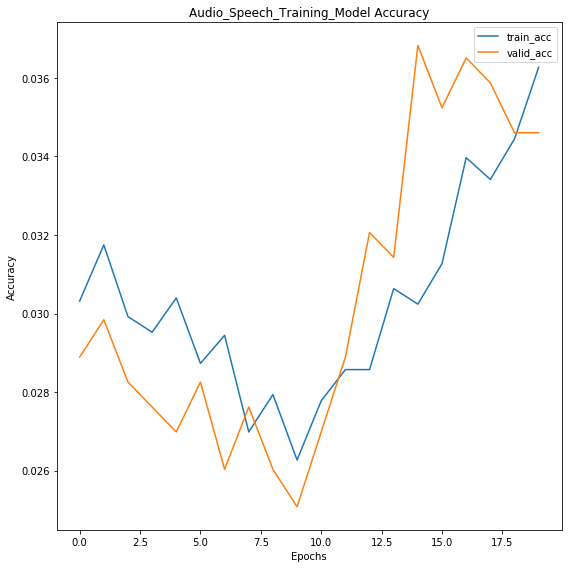

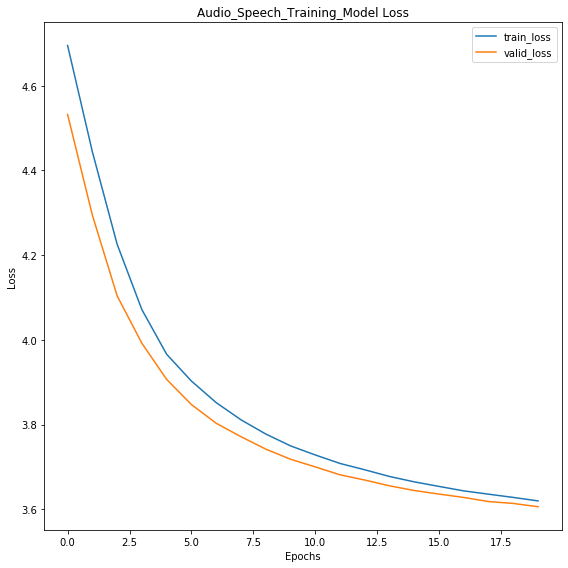

In [33]:
''' 
tf.Graph()
建立一個空的模型圖層 
https://www.tensorflow.org/api_docs/python/tf/Graph#__init__
'''
train_graph = tf.Graph()
train_sess = tf.compat.v1.Session(graph=train_graph)
tf.compat.v1.keras.backend.set_session(train_sess)

with train_graph.as_default():
    ''' 
        設置學習階段執行動作，給予整數設置此處設為1，代表進行Train 
        https://keras.io/backend/
    '''    
    tf.keras.backend.set_learning_phase(1)
    
    ''' 建置模型架構實體 '''
    net_model = build_model()

    ''' 輸出顯示模型架構總體資訊 '''
    net_model.summary()

    ''' 
    建立量化之訓練圖層，將輸入圖層重新建置模擬量化
    需要注意此步驟必須在執行梯度優化(optimizer)之前，也就是要在模型建置前向與後向之間，做這一步插入量化圖層動作。
    https://www.tensorflow.org/api_docs/python/tf/contrib/quantize/create_training_graph
    '''
    tf.contrib.quantize.create_training_graph(
          input_graph=train_graph,  # 模型圖層
          quant_delay=quant_delay  # 設置訓練期間每多少回合，進行權重與激活函數兩者進行量化
    )

    '''
    進行模型圖層之梯度優化全域變量初始化
    https://www.tensorflow.org/api_docs/python/tf/initializers/global_variables?authuser=0&hl=zh-Tw
    '''
    train_sess.run(tf.compat.v1.global_variables_initializer())

    ''' 編譯模型架構 '''
    net_model.compile(
        loss=CNN_loss,  # 損失函數
        optimizer=CNN_optimizer,  # 優化函數(針對梯度下降)
        metrics=['accuracy']
    )

    ''' 訓練模型 '''
    history = net_model.fit(
        # 訓練資料集
        Train_DataSet,
        # 訓練資料集標籤
        Train_Labels,
        # 設置每一回合訓練資料量
        batch_size=steps_per_epoch,
        # 設置訓練幾回合
        epochs=epochs,
        # 是否觀察訓練過程，設值為1代表要顯示觀察
        verbose=verbose,
        # 設置驗證資料集
        validation_data=(Valid_DataSet, Valid_Labels),
        # 回調函數
        callbacks=callbacks
    )

    ''' 將模型結構輸出成圖片檔 '''
    plot_model(net_model, to_file=os.path.join(os.getcwd(), 'model', 'model_visualized.png'))

    ''' 將tensor圖層與紀錄點存檔 '''
    saver = tf.compat.v1.train.Saver()

    saver.save(train_sess, Model_checkpoints_Path)

    ''' 建立訓練過程之準確度與損失函數變化圖片 '''
    plot_figure(
        history,
        os.path.join(os.getcwd(), Plot_Figure_DirectoryName),
        "Audio_Speech_Training"
    )

    ''' 驗證訓練後模型 '''
    score = net_model.evaluate(
          Test_DataSet,
          Test_Labels,
          verbose=verbose
    )

    print("\n\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print("Evalluate Loss：[{:.2f}] | Accuracy：[{:.2f}] ".format(score[0], score[1]))
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

    ''' 儲存訓練後模型和權重 '''
    net_model.save_weights(Model_Weight_Path)
    net_model.save(Model_Path)


In [34]:
''' Eval model '''
eval_graph = tf.Graph()
eval_sess = tf.compat.v1.Session(graph=eval_graph)
tf.keras.backend.set_session(eval_sess)

with eval_graph.as_default():
    ''' 
        設置學習階段執行動作，給予整數設置此處設為0，代表進行Test
        https://keras.io/backend/
    '''
    tf.keras.backend.set_learning_phase(0)

    ''' 取得模型結構 '''
    eval_model = build_model()

    ''' 
        建立量化之驗證圖層，將輸入圖層重新建置模擬量化
        https://www.tensorflow.org/api_docs/python/tf/contrib/quantize/create_eval_graph
    '''
    tf.contrib.quantize.create_eval_graph(
          input_graph=eval_graph  # 模型圖層
    )

    ''' 取得模型內部結構，包含節點、內部函數數值等等 '''
    eval_graph_def = eval_graph.as_graph_def()

    # print("eval_graph_def：\n{}\n".format(
    #     eval_graph_def
    # ))

    ''' 重新載入儲存權重變數，透過儲存紀錄點(存放權重參數) '''
    saver = tf.compat.v1.train.Saver()  # for tf_nightly
    saver.restore(eval_sess, Model_checkpoints_Path)

    ''' 
        將模型中所有的圖層變量轉換成相同數值常量
        https://www.tensorflow.org/api_docs/python/tf/graph_util/convert_variables_to_constants
    '''
    # for tf_nightly
    frozen_graph_def = tf.compat.v1.graph_util.convert_variables_to_constants(
          eval_sess,
          eval_graph_def,
          [eval_model.output.op.name]
    )

    # print("[Train_Data]\n{}\n".format(
    #     [eval_model.output.op.name]
    # ))

    print("[Train_Data] Model_PB_Path：{}".format(Model_PB_Path))

    ''' 輸出pb格式模型 '''
    with open(Model_PB_Path, 'wb') as f:
      f.write(frozen_graph_def.SerializeToString())

INFO:tensorflow:Inserting fake quant op activation_Mul_quant after batch_normalization/batchnorm/mul_1
INFO:tensorflow:Inserting fake quant op activation_AddV2_quant after batch_normalization/batchnorm/add_1
INFO:tensorflow:Inserting fake quant op activation_Mul_quant after batch_normalization_1/batchnorm/mul_1
INFO:tensorflow:Inserting fake quant op activation_AddV2_quant after batch_normalization_1/batchnorm/add_1
INFO:tensorflow:Restoring parameters from /content/checkpoints/checkpoints
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 46 variables.
INFO:tensorflow:Converted 46 variables to const ops.
[Train_Data] Model_PB_Path：/content/model/frozen_model.pb


In [35]:
!ls model/

frozen_model.pb  model_visualized.png	      Speech_Recognition_Weight.h5
ModelCheckpoint  Speech_Recognition_Model.h5


# 9.進行pb模型轉換tflite

In [36]:
input_model_path = Model_PB_Path
output_model_path = Output_Model_Path

Start_Time = time.time()

'''
讀取來源模型，此來源模型為已凍結圖層之模型，針對使用
https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#from_frozen_graph
'''
converter = tf.lite.TFLiteConverter.from_frozen_graph(
    input_model_path,  # 模型來源
    input_arrays,  # 來自模型輸入張量之凍結圖層清單，實際上是輸入層之名稱
    output_arrays  # 來自模型輸出張量之凍結圖層清單，實際上是輸出層之名稱
)


'''
Class TFLiteConverter
https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#attributes

For 'inference_type' and 'inference_input_type' Attributes
-----------------------------------------------------------------------------------------------------------------------------
If inference_type is tf.uint8, signaling conversion to a fully quantized model from a quantization-aware trained input model,
then inference_input_type defaults to tf.uint8
如果converter.inference_type是tf.uint8，在信號轉換完整量化模型中，輸入模型經過量化感知訓練過程，預設inference_input_type為tf.uint8格式。

For 'inference_output_type' and 'inference_input_type' Attributes
-----------------------------------------------------------------------------------------------------------------------------
If inference_type is tf.uint8, signaling conversion to a fully quantized model from a quantization-aware trained output model,
then inference_output_type defaults to tf.uint8.
如果converter.inference_type是tf.uint8，在信號轉換完整量化模型中，輸入模型經過量化感知訓練過程，預設inference_output_type為tf.uint8格式。

'''

''' 設置權重型態轉換為 uint8 針對使用 '''
converter.inference_type = tf.uint8

'''
取得讀取模型之輸入層，回傳模型之輸入向量之名稱
Returns a list of the names of the input tensors.
https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#get_input_arrays
'''
input_arrays = converter.get_input_arrays()

# print("input_arrays: {}".format(input_arrays))

converter.quantized_input_stats = {
    input_arrays[0]: (0.0, 255.0)  # (mean, stddev)
}

'''
進行轉換模型為TFLite格式模型
https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter#convert
'''
tflite_model = converter.convert()


''' 輸出轉換後tflite格式模型 '''
with open(output_model_path, "wb") as f:
  f.write(tflite_model)

convert_speed_time = (time.time() - Start_Time)

print("\nConvert Speed Time: {:.2f}s\n".format(convert_speed_time))

print("\n[Model_to_TFLite] 讀取量化轉換後TFLite model >> [{}] <<".format(
        output_model_path
))

''' 
讀取轉換後 TFLite model and allocate tensors. 
https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter?hl=zh-Tw&authuser=0
'''
interpreter = tf.lite.Interpreter(model_path=output_model_path)
interpreter.allocate_tensors()

''' 取得 input and output tensors 資訊 '''
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\n[Model_to_TFLite] '{}' --> input_details：\n{}\n".format(
      str(output_model_path).split('/')[-1],
      input_details[0],
))

print("[Model_to_TFLite] '{}' --> output_details\n{}\n".format(
      str(output_model_path).split('/')[-1],
      output_details[0],
))

''' 取得驗證資料集 '''
valid_data_name = ""
valid_data = list()
valid_data_path = os.path.join(
    os.getcwd(),
    "tflite_model",
    "validdata",
)

for read_dir in os.listdir(valid_data_path):
  print("[Model_to_TFLite] Valid Directory：{}".format(read_dir))

  if os.path.isdir(os.path.join(valid_data_path, read_dir)):

    valid_data_name = read_dir

    print("[Model_to_TFLite] Valid Name：{}".format(valid_data_name))

    for read_file in os.listdir(os.path.join(valid_data_path, read_dir)):
      print("[Model_to_TFLite] Valid File：{}".format(read_file))
      with open(os.path.join(valid_data_path, read_dir, read_file), "r") as read:
        temp_read_content = read.readlines()

      for read_row in temp_read_content:
        # 將每一行先做去除尾巴換行符號，並進行資料切割
        read_row = str(read_row).rstrip(" \n").split(" ")

        temp_list = list()

        # 讀取已完成去除尾巴換行符號與進行資料切割之每列內之欄位資料
        for feature in read_row:
          # 存放每一列的欄位資料
          valid_data.append(float(feature))

valid_data = np.array(valid_data).astype('float32')
print("[Model_to_TFLite] Valid data：{}".format(valid_data))

''' 取得標準值與平均值 '''
std, mean = input_details[0]['quantization']
print("[Model_to_TFLite] std：{} , mean：{}".format(std, mean))
    
''' 將valid_data進行量化 '''
quantize_valid_data = (valid_data / std + mean).astype('uint8')
print("[Model_to_TFLite] quantize_data：{}".format(
    (valid_data / std + mean)))
print("[Model_to_TFLite] quantize_valid_data：{}".format(quantize_valid_data))

''' 將valid_data進行reshape，跟input_details[0]['shape']一樣格式 '''
sample_input_data = quantize_valid_data.reshape(input_details[0]['shape'])
print("[Model_to_TFLite] sample_input_data shape：{}".format(
      sample_input_data.shape))

''' 設定輸入層張量Data '''
interpreter.set_tensor(input_details[0]['index'], sample_input_data)

''' 進行模型調用 '''
interpreter.invoke()

predict_quantized_result = interpreter.get_tensor(
    output_details[0]['index']
)

print("[Model_to_TFLite] predict_quantized_result shape：{}".format(
    predict_quantized_result[0].shape
))

print("[Model_to_TFLite] {} ".format(
    predict_quantized_result[0]
))

get_prediction_index = np.argmax(predict_quantized_result[0])

print("[Model_to_TFLite] get_prediction_index：{} ".format(
        get_prediction_index
    ))

dbconn = sqlite3.connect(
    os.path.join(
        os.getcwd(),
          SQLite_DB_DirectoryName,
          SQLite_name
    )
)

curs = dbconn.cursor()

''' 查詢預測出來分類編號對應分類名稱 '''
SQL_select_syntax = '''SELECT {} FROM {} WHERE {} = '{}';
'''.format(
    column_Classname,  # 欄位名稱-ClassName
    db_TableName,  # 查詢資料表
    column_ClassNum,  # 欄位名稱-ClassNum
    get_prediction_index  # 預測分類編號結果
)

SQL_run = curs.execute(SQL_select_syntax)
SQL_result = curs.fetchall()

print("[Model_to_TFLite] predict_quantized_result：{}".format(
        SQL_result[0][0],
))

all_speed_time = (time.time() - Start_Time)

print("\nSpeed time: {:.2f}s\n".format(all_speed_time))

print("可在終端機使用下列命令，來進行EdgeTPU Compiler TFLite model\n>> edgetpu_compiler -s {} <<\n".format(
        output_model_path
))



Convert Speed Time: 1.90s


[Model_to_TFLite] 讀取量化轉換後TFLite model >> [/content/model/ASR_Model.tflite] <<

[Model_to_TFLite] 'ASR_Model.tflite' --> input_details：
{'name': 'conv2d_input', 'index': 18, 'shape': array([ 1, 20, 11,  1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0)}

[Model_to_TFLite] 'ASR_Model.tflite' --> output_details
{'name': 'dense_1/Softmax', 'index': 23, 'shape': array([ 1, 35], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0)}

[Model_to_TFLite] Valid Directory：down
[Model_to_TFLite] Valid Name：down
[Model_to_TFLite] Valid File：29dce108_nohash_3.txt
[Model_to_TFLite] Valid data：[-3.1460916e+02 -1.3937138e+02 -3.7170918e+01 -4.1634003e+01
 -1.2501553e+02 -2.3992955e+02 -3.0535568e+02 -3.0930374e+02
 -3.2327722e+02 -3.3880310e+02 -3.3696515e+02  6.9174919e+01
  8.5761543e+01  6.8076057e+01  6.6118744e+01  8.3211647e+01
  8.4880653e+01  4.8947605e+01  4.1261333e+01  3.5855350e+01
  3.2940983e+01

In [37]:
!ls model/

ASR_Model.tflite  ModelCheckpoint	Speech_Recognition_Model.h5
frozen_model.pb   model_visualized.png	Speech_Recognition_Weight.h5


# 10.進行edgetpu_compiler編譯轉換tflite

In [38]:
!edgetpu_compiler -s /content/model/ASR_Model.tflite

Edge TPU Compiler version 2.0.267685300

Model compiled successfully in 47 ms.

Input model: /content/model/ASR_Model.tflite
Input size: 102.83KiB
Output model: ASR_Model_edgetpu.tflite
Output size: 172.56KiB
On-chip memory available for caching model parameters: 7.96MiB
On-chip memory used for caching model parameters: 106.50KiB
Off-chip memory used for streaming uncached model parameters: 3.00KiB
Number of Edge TPU subgraphs: 1
Total number of operations: 12
Operation log: ASR_Model_edgetpu.log

Operator                       Count      Status

FULLY_CONNECTED                2          Mapped to Edge TPU
SOFTMAX                        1          Mapped to Edge TPU
ADD                            2          Mapped to Edge TPU
MAX_POOL_2D                    2          Mapped to Edge TPU
MUL                            2          Mapped to Edge TPU
CONV_2D                        2          Mapped to Edge TPU
DEPTHWISE_CONV_2D              1          Mapped to Edge TPU


# 11.下載經過*edgetpu_compiler*編譯轉換後tflite檔案

In [0]:
from google.colab import files
files.download('/content/model/ASR_Model.tflite')